In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

2022-04-30 20:57:31.261112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 20:57:31.261172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [87]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
from gtts import gTTS 
from IPython.display import Audio 
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [2]:
#Open data
data_file = open('Data.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer(char_level = False)

data = data_file.lower().splitlines()

data = list(filter(lambda x: x != '##', data))

new_data = data

for paragraph in range(len(data)):
    sentences = data[paragraph].split('.')
    if sentences != ' ':
        new_data[paragraph] = sentences
    
    
#data = data = np.vstack([[new_data[0:-1]]]).T
data = new_data
#data

In [3]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'
new_data = data
max_sentence_length = 0

for paragraph in range(len(data)):
    para = data[paragraph]

    for sentence in range(len(para)):
        para[sentence] = start_token + para[sentence]
        para[sentence] = para[sentence] + end_token

        num_words =  len(para[sentence].split())
        if max_sentence_length < num_words:
            max_sentence_length = num_words

    new_data[paragraph] = para
      

data = new_data
#data

In [4]:
def Encode_Inputs(data, max_sentence_length):
    input_sequences = list()
    output_sequences = list()
    
    for paragraph in range(len(data)):
        para = data[paragraph]

        tokenized_sentence = para
        tokenizer.fit_on_texts(tokenized_sentence)

        #Transforms sentences into set of integers from the dictionary
        tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)

        #Pad sequences to length of max_length
        tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = max_sentence_length, padding ='post', value = 0)
        total_words = len(tokenizer.word_index) + 1    

        roll_amount = tokenized_sentence.shape[1] * (tokenized_sentence.shape[0]-1)
        output_tokens = np.array(np.roll(tokenized_sentence, roll_amount))
        output_tokens[-1] = 0

        input_sequences.append(tokenized_sentence)
        output_sequences.append(output_tokens)

    input_sequences = np.vstack(input_sequences)
    output_sequences = np.vstack(output_sequences)
    
    return input_sequences, output_sequences, total_words

In [5]:
def Decode_Inputs(input_sequences):

    data = tokenizer.sequences_to_texts(input_sequences)
    return data

In [6]:
start_end = token = np.zeros(max_sentence_length,)
start_end[0] = 1
start_end[1] = 2
start_end

array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [10]:
input_sequences, output_sequences, total_words = Encode_Inputs(data, max_sentence_length)
post_output_sequences = output_sequences[:,0:][:]
print(total_words)
decoded = Decode_Inputs(output_sequences)
print(input_sequences.shape)
print(output_sequences.shape)
print(post_output_sequences.shape)
print('Input:', Decode_Inputs(input_sequences)[0])
print('Target:', Decode_Inputs(post_output_sequences)[0])
input_sequences
for seq in range(len(input_sequences)):
    if  not np.array_equal(input_sequences[seq], start_end):
        input_sequences[seq] = input_sequences[seq]
input_sequences

4547
(1902, 88)
(1902, 88)
(1902, 88)
Input: start the important thing is not to stop questioning end
Target: start curiosity has its own reason for existence end


array([[   1,    3,  262, ...,    0,    0,    0],
       [   1, 2245,   48, ...,    0,    0,    0],
       [   1,   37,  132, ...,    0,    0,    0],
       ...,
       [   1,    6,   29, ...,    0,    0,    0],
       [   1,    6,   29, ...,    0,    0,    0],
       [   1,    2,    0, ...,    0,    0,    0]], dtype=int32)

In [11]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer_Block, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [13]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [15]:
input_sequences[0]

array([   1,    3,  262,  222,   12,   21,    5,  930, 2244,    2,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [16]:
Decode_Inputs(input_sequences)[0]

'start the important thing is not to stop questioning end'

In [17]:
#Variables
embed_dim = 128
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 6
ff_dim = 16
dropout = 0.15

encoder_stack = 4
decoder_stack = 4

2022-04-30 20:57:53.955819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 20:57:53.955885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 20:57:53.955940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-klg6z): /proc/driver/nvidia/version does not exist
2022-04-30 20:57:53.956280: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


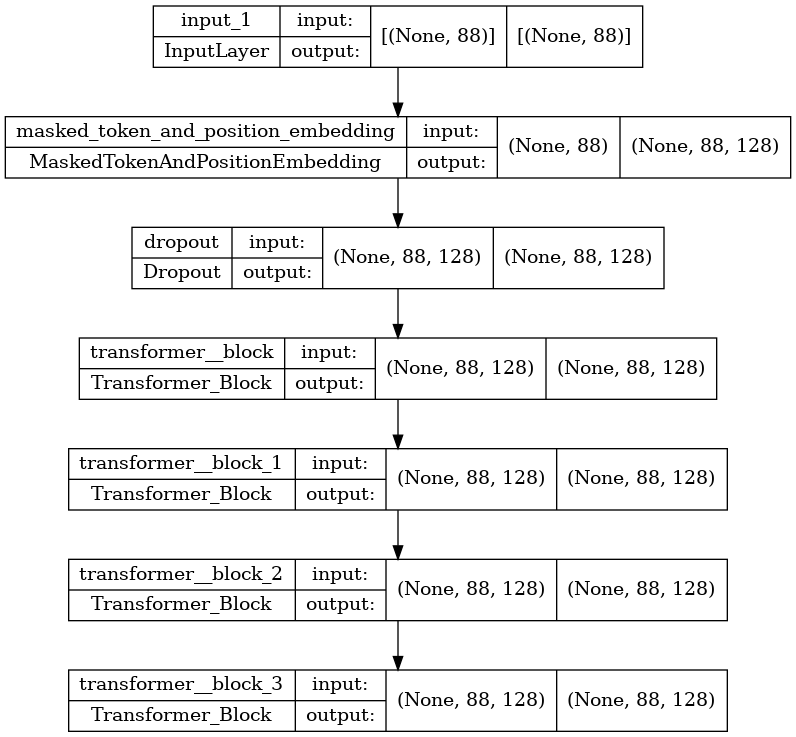

In [18]:
#Encoder

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1:])
encoder = MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout_layer = keras.layers.Dropout(dropout, noise_shape=encoder.shape[:-1]+(1,))(encoder)
encoder = dropout_layer

for i in range(encoder_stack):
      encoder = Transformer_Block(embed_dim, num_heads, ff_dim, dropout)(encoder)                                                                    

encoder_model = keras.Model(input_layer, encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

In [19]:
# result = encoder_model.predict(input_sequences)
# print('Input:', Decode_Inputs(result.argmax(0-1)))

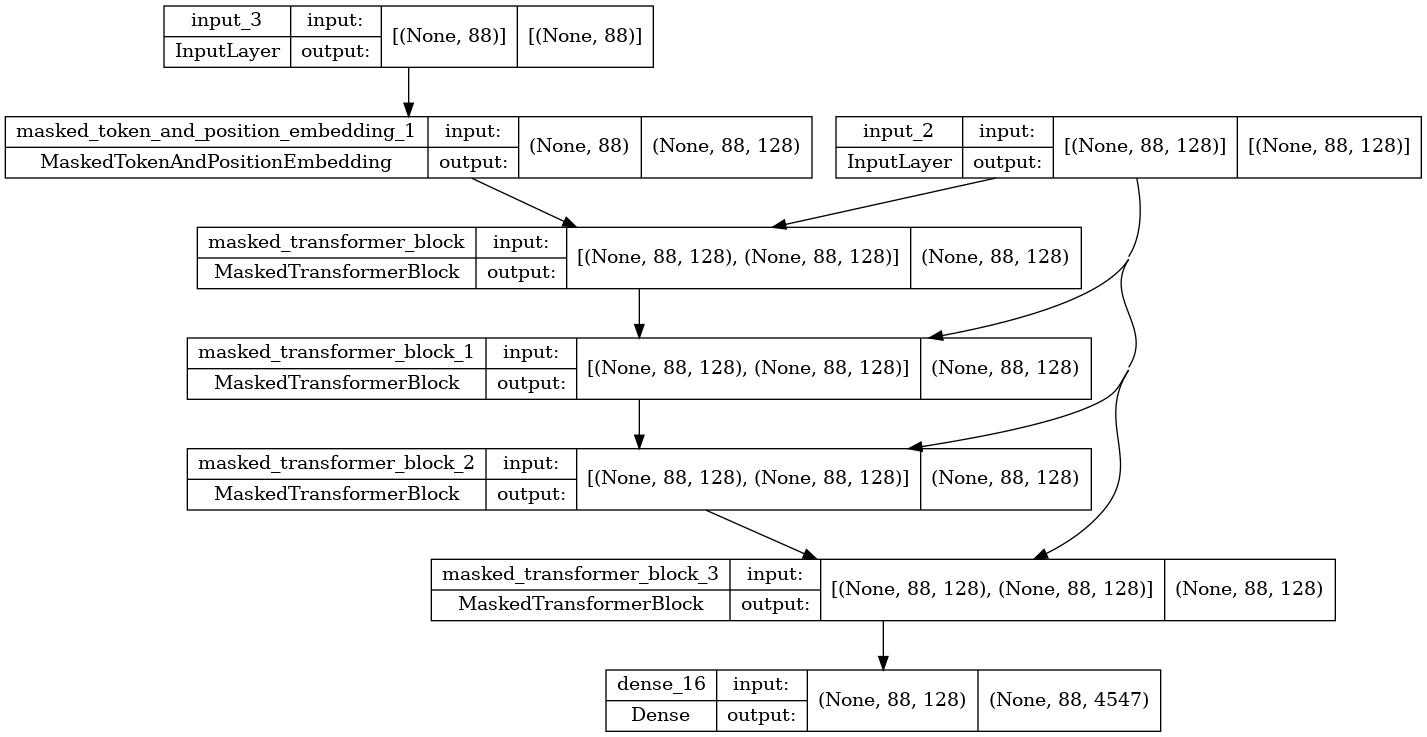

In [20]:
#Decoder 

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1:])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(total_words)(decoder)

decoder_model = keras.Model([input_layer, encoder_input_layer], linear_layer)
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

In [21]:
# context = encoder_model.predict(input_sequences)
# token = np.zeros(output_sequences.shape)
# token[:,0] = 1 
# for x in range(output_sequences.shape[1]-1):
#     result = decoder_model.predict([token,context]).argmax(-1)
#     token[:,x+1] = result[:,x]
# result = decoder_model.predict([token,context])
# print('Input:', Decode_Inputs(result.argmax(0-1)))

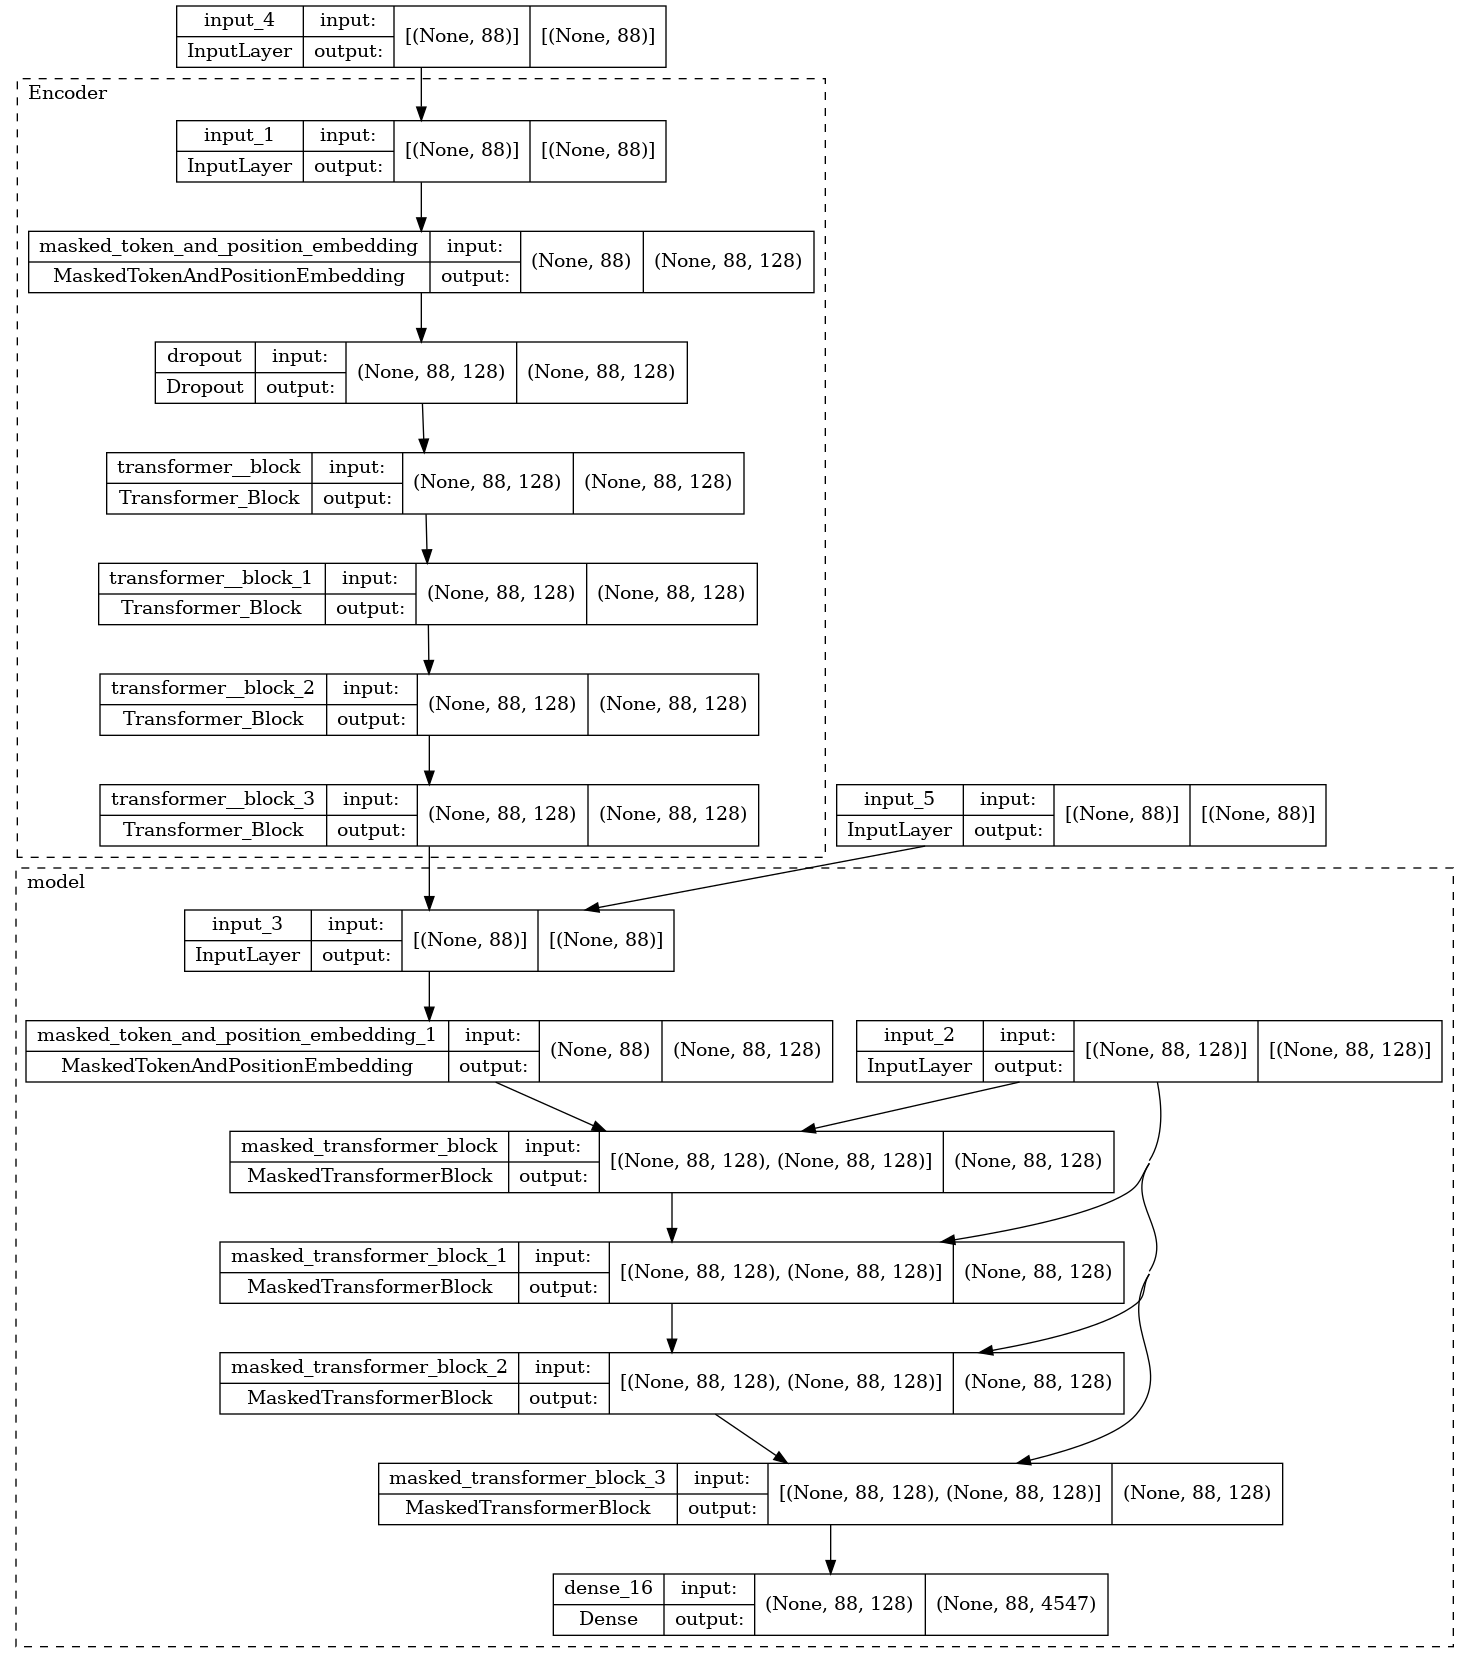

In [22]:
sequences = keras.layers.Input(encoder_model.input_shape[1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])

transformer = decoder_model([targets, encoder_model(sequences)])
transformer = keras.Model([sequences, targets], transformer)

keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [23]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 88, 128)      2195008     ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 88, 4547)     4364163     ['input_5[0][0]',                
                                                                  'Encoder[0][0]']          

In [ ]:
batch_size = 10
epochs = 10

history = transformer.fit([input_sequences, output_sequences], post_output_sequences, batch_size=batch_size, epochs=epochs, validation_data=([input_sequences, output_sequences], post_output_sequences), verbose=1)

Epoch 1/10
191/191 [==============================] - 310s 2s/step - loss: 3.6609 - MaskedSparseCategoricalAccuracy: 0.5939 - val_loss: 1.3660 - val_MaskedSparseCategoricalAccuracy: 0.9084
Epoch 2/10
191/191 [==============================] - 286s 1s/step - loss: 0.9752 - MaskedSparseCategoricalAccuracy: 0.9253 - val_loss: 0.5074 - val_MaskedSparseCategoricalAccuracy: 0.9883
Epoch 3/10
191/191 [==============================] - 286s 1s/step - loss: 0.4275 - MaskedSparseCategoricalAccuracy: 0.9896 - val_loss: 0.2222 - val_MaskedSparseCategoricalAccuracy: 0.9999
Epoch 4/10
191/191 [==============================] - 286s 1s/step - loss: 0.1972 - MaskedSparseCategoricalAccuracy: 0.9999 - val_loss: 0.0758 - val_MaskedSparseCategoricalAccuracy: 1.0000
Epoch 5/10
191/191 [==============================] - 286s 1s/step - loss: 0.0652 - MaskedSparseCategoricalAccuracy: 1.0000 - val_loss: 0.0192 - val_MaskedSparseCategoricalAccuracy: 1.0000
Epoch 6/10
191/191 [==============================] - 2

In [25]:
print('Training Accuracy:',transformer.evaluate([input_sequences, output_sequences] ,post_output_sequences)[1]*100.0,'%')

60/60 [==============================] - 76s 1s/step - loss: 0.0027 - MaskedSparseCategoricalAccuracy: 1.0000
Training Accuracy: 100.0 %


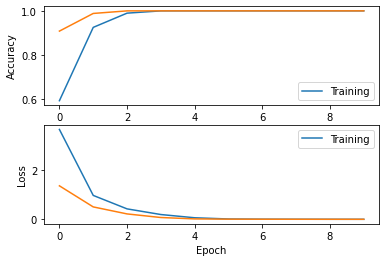

In [26]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='upper right') 

In [28]:
i = 0
print('Input:',input_sequences[i])
print('Output:', post_output_sequences[i])

Input: [   1    3  262  222   12   21    5  930 2244    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Output: [   1 2245   48  118  438  275   13  931    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [29]:
print('Input:', Decode_Inputs(input_sequences)[i])
print('Target:', Decode_Inputs(post_output_sequences)[i])

Input: start the important thing is not to stop gravity end
Target: start questioning has its own reason for existence end


In [128]:
#Teacher Forcing
def TF_Output_Predictions(i):    
    result = transformer.predict([input_sequences[i:i+1],output_sequences[i:i+1]])
    result.argmax(-1)[0]
    accuracy = MaskedSparseCategoricalAccuracy(post_output_sequences[i:i+1],result).numpy()*100.0
    result = Decode_Inputs(result.argmax(-1))
    inputS = Decode_Inputs(input_sequences[i:i+1])
    
    return result, accuracy, inputS

In [129]:
result, accuracy, inputS = TF_Output_Predictions(0)
print(inputS)
print()
print(result)
print(accuracy)

['start the important thing is not to stop gravity end']

['start questioning has its own reason for existence end now now now now now now now now now now now now all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all']
100.0


In [130]:
#Non Teacher Forcing
def NTF_Output_Prediction(sentence):
    #Tokenize sentence
    tokenized_sentence = ['theory of relativity']
    tokenized_sentence[0] = start_token + tokenized_sentence[0]
    tokenized_sentence[0] = tokenized_sentence[0] + end_token
    tokenizer.fit_on_texts(tokenized_sentence)
    tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)
    tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = max_sentence_length, padding ='post', value = 0)
    
    #Pass into model
    context = encoder_model.predict(tokenized_sentence)
    token = np.zeros(tokenized_sentence.shape)
    token[:,0] = 1 
    result = decoder_model.predict([token,context]).argmax(-1)
    token[:,1] = result[:,1]
    result = decoder_model.predict([token,context])
    result = Decode_Inputs(result.argmax(-1))
    
    
    return result

In [303]:
NTF_Output_Prediction('einstein')

['start this now now now all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all all']

In [236]:
#Image
file = open("Einstein.png", "rb")
image = file.read()

image_headline = widgets.Image(
                    value=image,
                    format='jpg',
                    width='300'
                )

image = widgets.VBox([image_headline])

In [329]:
#Enter your name
name = widgets.Text(placeholder='Enter your name')

In [330]:
enter_number = widgets.Text(placeholder='Enter a number')
enter_sentence = widgets.Text(placeholder='Enter a sentence')

In [446]:
#Buttons
Teacher_Forcing = widgets.Button(
                description="I'm Feeling Lucky!",
                tooltip='Send',
                style={'description_width': 'initial'}
            )

Non_Teacher_Forcing = widgets.Button(
                description="I'm Feeling Unlucky.",
                tooltip='Send',
                style={'description_width': 'initial'}
            )

outputTF = widgets.Output()
outputNTF = widgets.Output()


def On_TF_Clicked(event):
    with outputTF:
        clear_output()
        intro = 'Dear ' + name.value
        outro = 'Sincerely Einstein'
        print(intro)
        resultTF, accuracy, inputS = TF_Output_Predictions(int(enter_number.value))  
        print(inputS[0],'\n', resultTF[0], '\n', outro, '\nAccuracy: ', accuracy)
        tts = gTTS(intro + resultTF[0] + outro, tld='com.au') 
        tts.save('1.wav') 
        sound_file = '1.wav'
        display(Audio(sound_file, autoplay=True) )
        
        
def On_NTF_Clicked(event):
    with outputNTF:
        clear_output()
        intro = 'Dear ' + name.value
        outro = 'Sincerely Einstein'
        print(intro)
        resultNTF = NTF_Output_Prediction(' ' + enter_sentence.value)
        print(enter_sentence.value, '\n', resultNTF[0], '\n', outro)
        tts = gTTS(intro + resultNTF[0] + outro, tld='com.au') #Provide the string to convert to speech
        tts.save('2.wav') #save the string converted to speech as a .wav file
        sound_file2 = '2.wav'
        display(Audio(sound_file2, autoplay=True) )

In [447]:
Teacher_Forcing.on_click(On_TF_Clicked)
Non_Teacher_Forcing.on_click(On_NTF_Clicked)
TF = widgets.VBox([Teacher_Forcing, outputTF])
NTF = widgets.VBox([Non_Teacher_Forcing, outputNTF])

In [448]:
vbox_text = widgets.VBox([name, enter_number, TF, enter_sentence, NTF])

In [450]:
page = widgets.HBox([image, vbox_text])
display(page)